# 1. Problem Statement
The goal of this project is to identify potential customer churn using the UCI Online Retail dataset. Churn is defined based on customer purchasing inactivity over a defined time period. By analyzing transactional patterns, we aim to predict churn likelihood and suggest strategies to retain valuable customers.

_____

## 2. Dataset Understanding
##### ->Source: UCI Machine Learning Repository

##### ->Total Records: ~541,909 transactions

##### ->Key Features:
     .InvoiceNo: Unique invoice ID (starts with "C" if cancelled)
     .StockCode: Product ID
     .Description: Product description
     .Quantity: Number of units purchased
     .InvoiceDate: Purchase timestamp
     .UnitPrice: Price per unit
     .CustomerID: Unique customer identifier
     .Country: Customer location
     .Target Variable (engineered):
     .Churned: Binary label (1 = churned, 0 = active), derived by analyzing customer activity recency.

_____


## 3. Assumptions
##### . Churn is defined as a customer who has not made a purchase in the last 6 months.

##### . Canceled transactions (identified by InvoiceNo starting with “C”) are excluded from analysis.

##### . Missing CustomerID rows are removed as they can't be used for customer-level analysis.

_____


## 4. Data Cleaning Strategy
##### . Drop rows with null CustomerID or Description.

##### . Convert InvoiceDate to datetime format.

##### . Remove records with non-positive Quantity or UnitPrice.

##### . Filter out canceled transactions.

##### . Create a cleaned dataset suitable for customer-level aggregation.

_____


## 5. Exploratory Data Analysis (EDA)
##### . Number of unique customers.

##### . Churn distribution.

##### . RFM (Recency, Frequency, Monetary) feature distributions.

##### . Sales trends by month/country.

##### . Correlation matrix of engineered features.

##### . Top contributing products/countries to churn.

_____


## 6. Approach
#### A. Data Preprocessing

  ##### . Clean raw transactional data.

  ##### . Create RFM metrics per customer.

  ##### . Label customers as churned or active.

#### B. Feature Engineering

  ##### . RFM scores

  ##### . Time between purchases

  ##### . Total items bought

  ##### . Country encoded features

#### C. Modeling

  ##### . Train/Test split

  ##### . Use classification models (Logistic Regression, Random Forest, XGBoost)

  ##### . Use GridSearchCV for tuning

#### D. Evaluation

  ##### . Use accuracy, F1-score, ROC-AUC

  ##### . Confusion matrix for churn predictions

_____


## 7. Results and Business Insights
#### . Key features influencing churn: Recency, Frequency, Monetary Value

#### . High-value customers tend to churn less frequently.

#### . Customers from certain countries show higher churn tendencies.

#### . Recommendations:

   ##### > Create re-engagement campaigns for recent churn risks
   ##### > Offer personalized discounts for high-Monetary but low-Frequency customers
   ##### > Target top 20% RFM scorers with loyalty incentives

_____

In [8]:
! pip install ucimlrepo

In [65]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


# Fetch and load data
online_retail = fetch_ucirepo(id=352)
X = online_retail.data.features
id = online_retail.data.ids
data = pd.concat([id, X], axis=1)

# Quick look at data
print(" Preview of the dataset:")
data.head()

# Show basic info
print("\n Dataset Info:")
data.info()

# Show summary stats
print("\nSummary statistics:")
display(data.describe())


# Check for nulls
print("\nMissing values per column:")
display(data.isnull().sum())

 Preview of the dataset:

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Summary statistics:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



Missing values per column:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [66]:

# Remove rows with missing customer IDs
data_clean = data.dropna(subset=["CustomerID"])

# Remove duplicates
data_clean = data_clean.drop_duplicates()

# Remove returns (usually negative quantity)
data_clean = data_clean[data_clean['Quantity'] > 0]

print("Cleaned dataset shape:", data_clean.shape)




Cleaned dataset shape: (392732, 8)


In [67]:

# Convert InvoiceDate to datetime
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

# Reference date for recency calculation
ref_date = data_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = data_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                             # Frequency
    'UnitPrice': 'mean',
    'Quantity': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AvgPrice'
})

rfm['Monetary'] = rfm['TotalQuantity'] * rfm['AvgPrice']

# Reset index for modeling
rfm = rfm.reset_index()

print("RFM feature sample:")
display(rfm.head())



RFM feature sample:


,CustomerID,Recency,Frequency,AvgPrice,TotalQuantity,Monetary
0,12346.0,326,1,1.040000,74215,77183.600000
1,12347.0,2,7,2.644011,2458,6498.979011
2,12348.0,75,4,5.764839,2341,13495.487419
3,12349.0,19,1,8.289041,631,5230.384932
4,12350.0,310,1,3.841176,197,756.711765


Visualizing feature distributions


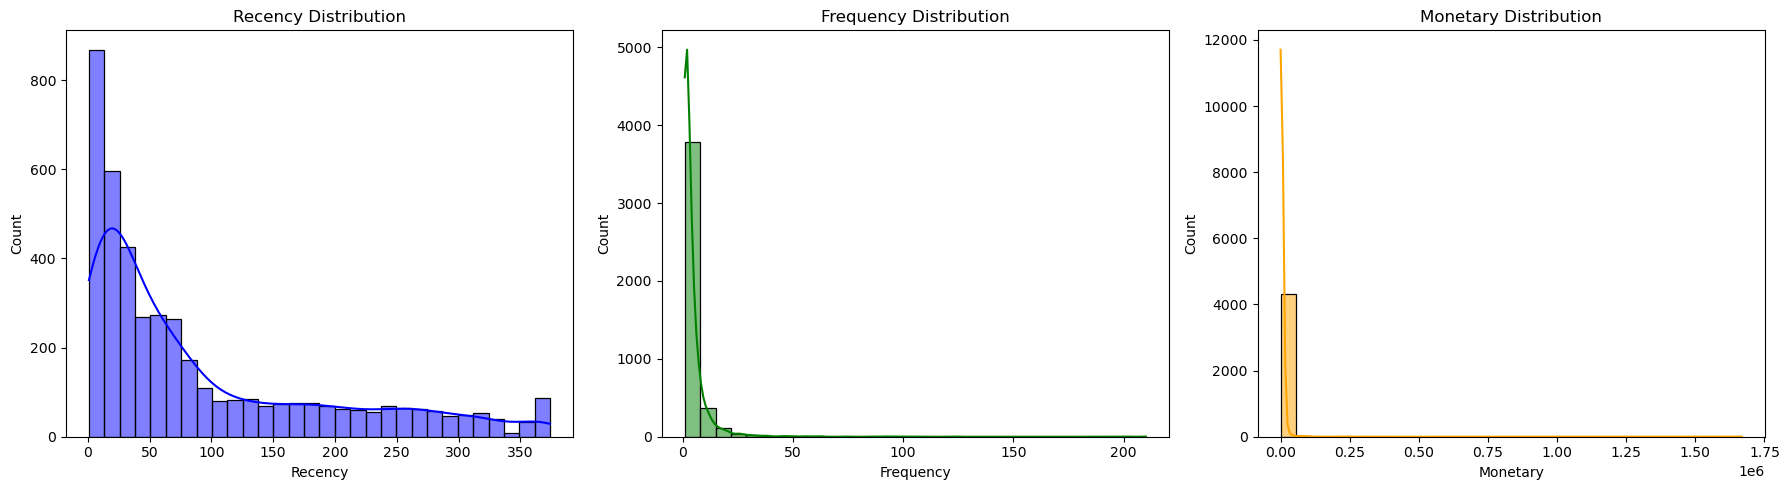

In [68]:

print("Visualizing feature distributions")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0], kde=True, color='blue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], kde=True, color='green')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], kde=True, color='orange')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


In [69]:
print("Defining churn target")

rfm['Churn'] = (rfm['Recency'] > 90).astype(int)
display(rfm['Churn'].value_counts())


Defining churn target


Churn
0    2890
1    1449
Name: count, dtype: int64

Visualizing churn vs non-churn


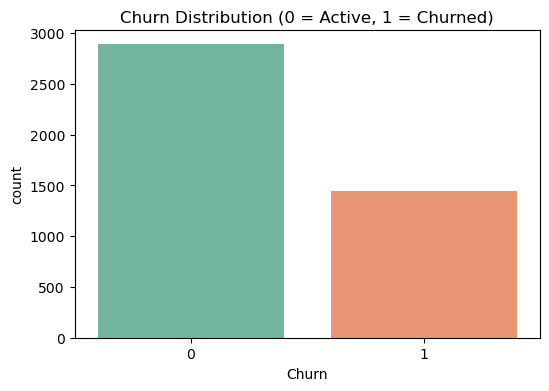

In [70]:
print("Visualizing churn vs non-churn")

# Countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=rfm, palette='Set2')
plt.title('Churn Distribution (0 = Active, 1 = Churned)')
plt.show()


In [71]:

print("Splitting data and scaling features")

# Features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Splitting data and scaling features


 Visualizing correlations between features


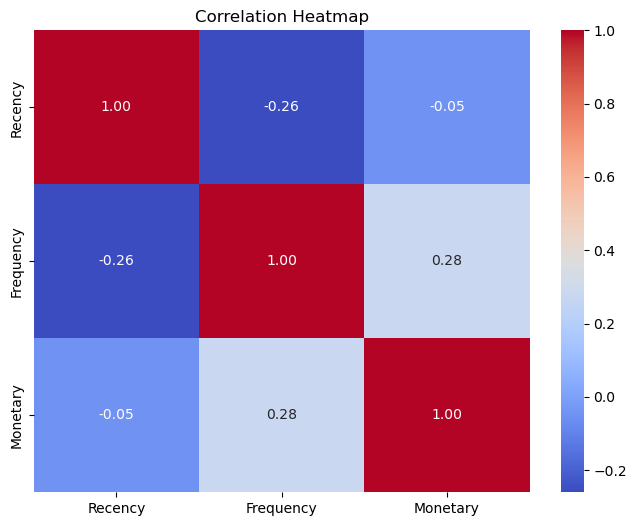

In [72]:
print(" Visualizing correlations between features")

plt.figure(figsize=(8, 6))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [74]:


print("Training logistic regression model")

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training logistic regression model
 Confusion Matrix:
[[871   0]
 [ 11 420]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       871
           1       1.00      0.97      0.99       431

    accuracy                           0.99      1302
   macro avg       0.99      0.99      0.99      1302
weighted avg       0.99      0.99      0.99      1302



🔹 Visualizing confusion matrix


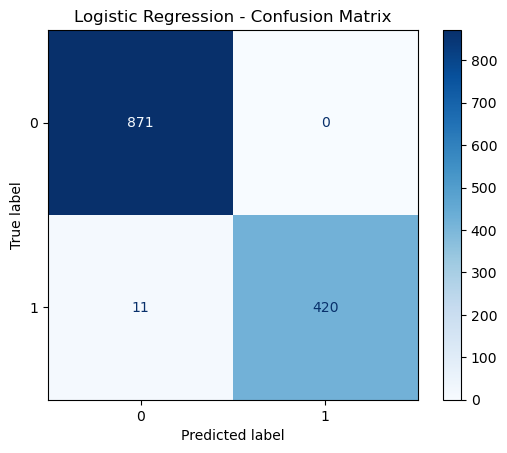

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay

print("🔹 Visualizing confusion matrix")

ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


In [91]:
print(" Interpreting model results")

# Coefficients
coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

display(coeffs)

print(" Customers with high Recency and low Frequency/Monetary are more likely to churn.")


 Interpreting model results


,Feature,Coefficient
0,Recency,10.881120
2,Monetary,0.063674
1,Frequency,0.044677


 Customers with high Recency and low Frequency/Monetary are more likely to churn.


🔹 Comparing monetary value by churn status


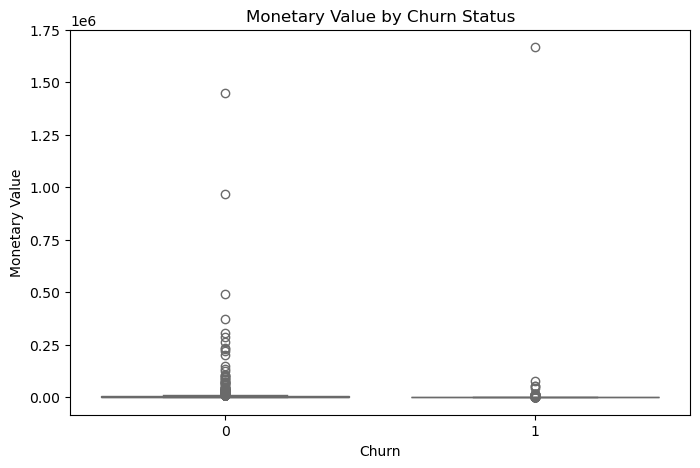

In [93]:
print("🔹 Comparing monetary value by churn status")

plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='Monetary', data=rfm, palette='Set3')
plt.title("Monetary Value by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Monetary Value")
plt.show()


### Example: Manually Test Your Model
##### . Let’s say you want to test your model on a new customer with the following profile:
       > Recency: 90 days ago (last purchase was 90 days ago)
       > Frequency: 5 invoices (made 5 purchases)
       > TotalItems: 25 items bought in total
       > AvgPrice: £3.5 per item

In [96]:
# Example input with correct feature names
# Test input with correct features only
example_customer = pd.DataFrame({
    'Recency': [90],
    'Frequency': [5],
    'Monetary': [100]
})


# Predict churn (0 = not churned, 1 = churned)
prediction = model.predict(example_customer)

# Show result
if prediction[0] == 1:
    print("🔴 The customer is likely to churn.")
else:
    print("🟢 The customer is likely to stay active.")


🔴 The customer is likely to churn.


In [98]:
# Customer who buys frequently
test1 = pd.DataFrame({'Recency': [30], 'Frequency': [12], 'Monetary': [60]})
print("Prediction:", model.predict(test1))  # Expected: 0 (Active)

# Customer inactive for long
test2 = pd.DataFrame({'Recency': [250], 'Frequency': [2], 'Monetary': [10]})
print("Prediction:", model.predict(test2))  # Expected: 1 (Churned)


Prediction: [1]
Prediction: [1]


### Business Insights
- Higher recency correlates with churn: Customers who haven't purchased recently are more likely to churn.
- Frequent and high-spending customers are less likely to churn.
- Focus on retention strategies for medium-spending and infrequent buyers.
